# CAOL vs. NN-CAOL

Here, we reconstruct imagse using the network described in our paper:

https://arxiv.org/abs/2203.02166

Further, we compare the results when using the same network architecture by using filters pre-trained using the following method

https://ieeexplore.ieee.org/document/8822606

and the ones obtained by supervised end-to-end training.

### 1) Load data and create instance of object which contains the data-acquisition model

In [2]:
import torch
import torch.nn as nn

from networks.encoding_object import Dyn2DRadEncObj
from networks.caol_network import ConvAnaOpLearningCNN

from utils.noise_funcs import add_gaussian_noise
from utils.cplx_helper_funcs import cplx_np2torch, cplx_torch2np
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

#datatype
dtype = torch.float

#wheter to use the gpu or not;
use_GPU=1

#load data
xf = np.load('toy_data/img_320.npy')
ktraj = np.load('toy_data/ktraj_320.npy') 
csm = np.load('toy_data/csmap_320.npy')
dcomp = np.load('toy_data/dcomp_320.npy')  #shape (Nrad,20)

#convert to tensors
xf_tensor = cplx_np2torch(xf,0).unsqueeze(0).unsqueeze(0) # (1,1,2,320,320,20)
ktraj_tensor = cplx_np2torch(ktraj,0).unsqueeze(0) # (1,2,11520,20)
csm_tensor = cplx_np2torch(csm,1).unsqueeze(0) #(1,12,2,320, 320)
dcomp_tensor = torch.tensor(dcomp).unsqueeze(0).unsqueeze(0).unsqueeze(0) 

#create encoding operator object
im_size = xf.shape

if use_GPU:
	xf_tensor = xf_tensor.to('cuda')
	ktraj_tensor = ktraj_tensor.to('cuda')
	csm_tensor = csm_tensor.to('cuda')
	dcomp_tensor = dcomp_tensor.to('cuda')
	
	EncObj = Dyn2DRadEncObj(im_size,ktraj_tensor,dcomp_tensor,csm_tensor,norm='ortho').cuda()
else:
	EncObj = Dyn2DRadEncObj(im_size,ktraj_tensor,dcomp_tensor,csm_tensor,norm='ortho')
	
print('successfully generated data-acquisition model')
with torch.no_grad():
	#generate k-sace data, add noise
	ku_tensor = EncObj.apply_A(xf_tensor)
	ku_tensor = add_gaussian_noise(ku_tensor,sigma=.05)
	
	#get initial reconstruction
	xu_tensor = EncObj.apply_Adag(ku_tensor)
	
xu = cplx_torch2np(xu_tensor.squeeze(0).squeeze(0).detach().cpu(),0)

successfully generated data-acquisition model


### 2) Compare CAOL and NN-CAOL for different number of filters and filter-sizes

apply caol with K=16, k=3
apply nn_caol with K=16, k=3
apply caol with K=16, k=5
apply nn_caol with K=16, k=5
apply caol with K=16, k=7
apply nn_caol with K=16, k=7
apply caol with K=24, k=3
apply nn_caol with K=24, k=3
apply caol with K=24, k=5
apply nn_caol with K=24, k=5
apply caol with K=24, k=7
apply nn_caol with K=24, k=7


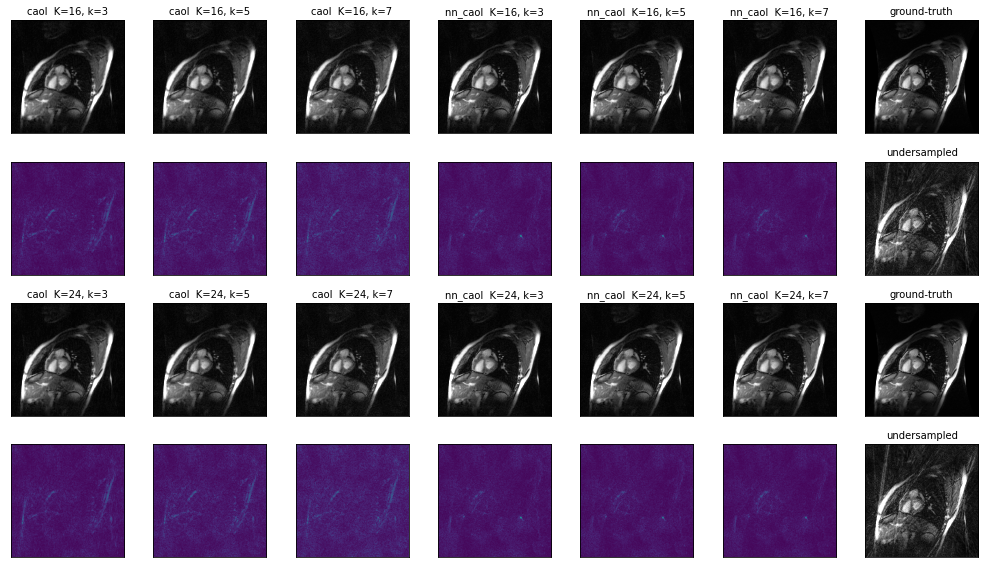

In [4]:
#define reconstruction network params
npcg = 4
version = 'version1' #or version2

n_filters_ist = [16,24]
kernel_size_list = [3,5,7]

figsize = 2
Nfigs_x = 2 * len(n_filters_ist)
Nfigs_y = 2 * len(kernel_size_list) +1 

fig,ax = plt.subplots(Nfigs_x, Nfigs_y, figsize = (figsize * Nfigs_y, figsize * Nfigs_x))
factor = 2.
cutoff=40
kt=12

fontsize=10
for i,n_filters in enumerate(n_filters_ist,0):
		
	for j,kernel_size in enumerate(kernel_size_list,0):
            
		
		for k, approach in enumerate(['caol','nn_caol'],0):
			
			if approach == 'nn_caol':
				nu = 4
				
			elif approach == 'caol':
				
				#although trained with nu=4, possibility to increase nu,
				#see also in the paper
				nu=12 
			
			title = approach + '  K={}, k={}'.format(n_filters, kernel_size)
			print('apply {} with K={}, k={}'.format(approach,n_filters,kernel_size))
			caol_nn = ConvAnaOpLearningCNN(EncObj,
											nu=nu, 
											npcg=npcg, 
											n_filters=n_filters, 
											kernel_size=kernel_size,
											version=version)
			
			if use_GPU:
				caol_nn = caol_nn.cuda()
				
			#load pre-trained model
			caol_nn.load_state_dict(torch.load('networks/pre_trained_models/caol_version1/{}_K{}_k{}.pt'.format(approach, n_filters, kernel_size)))
			
			with torch.no_grad():
				
				xcnn_tensor = caol_nn(xu_tensor.squeeze(0))
			
			xcnn = cplx_torch2np(xcnn_tensor.squeeze(0).detach().cpu(),0)
			
			ax[2*i,j+3*k].imshow(np.abs(xcnn)[cutoff:-cutoff, cutoff:-cutoff, kt],cmap=plt.cm.Greys_r,clim=[0,1000])
			ax[2*i,j+3*k].set_title(title, fontsize=fontsize)
			ax[2*i+1,j+3*k].imshow(factor * np.abs(xcnn-xf)[cutoff:-cutoff, cutoff:-cutoff, kt],cmap=plt.cm.viridis,clim=[0,1000])
			
   	
	ax[2*i,-1].imshow(np.abs(xf)[cutoff:-cutoff, cutoff:-cutoff, kt],cmap=plt.cm.Greys_r,clim=[0,1000])
	ax[2*i,-1].set_title('ground-truth', fontsize=fontsize)
	ax[2*i+1,-1].imshow(np.abs(xu)[cutoff:-cutoff, cutoff:-cutoff, kt],cmap=plt.cm.Greys_r,clim=[0,1000])
	ax[2*i+1,-1].set_title('undersampled', fontsize=fontsize)
		
for i in range(Nfigs_x):
	for j in range(Nfigs_y):
		ax[i,j].set_xticks([])	
		ax[i,j].set_yticks([])
		
plt.tight_layout()